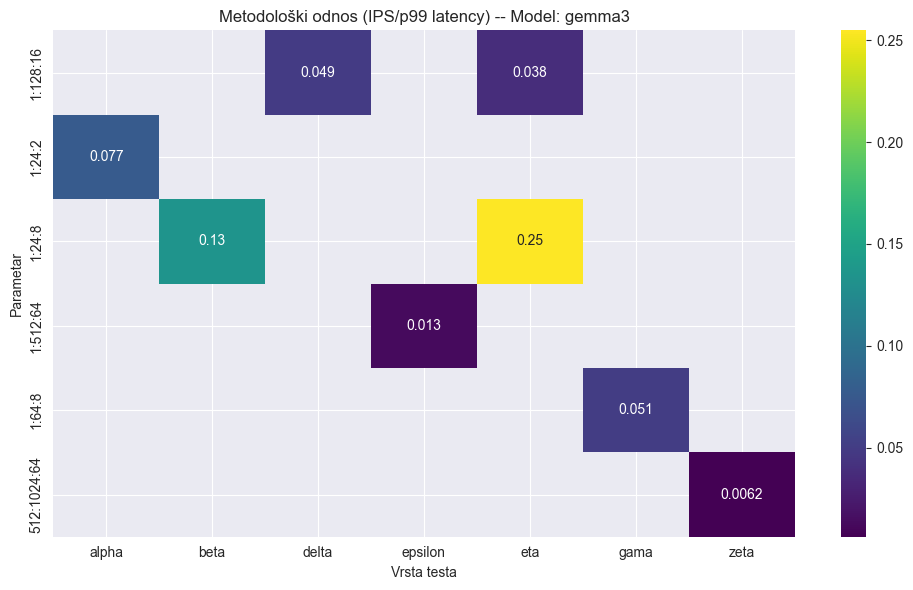

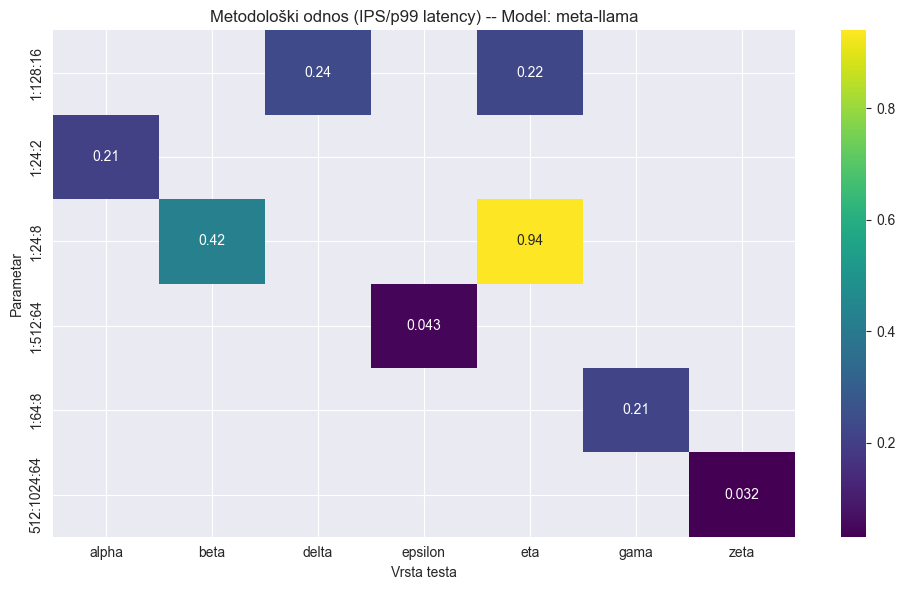

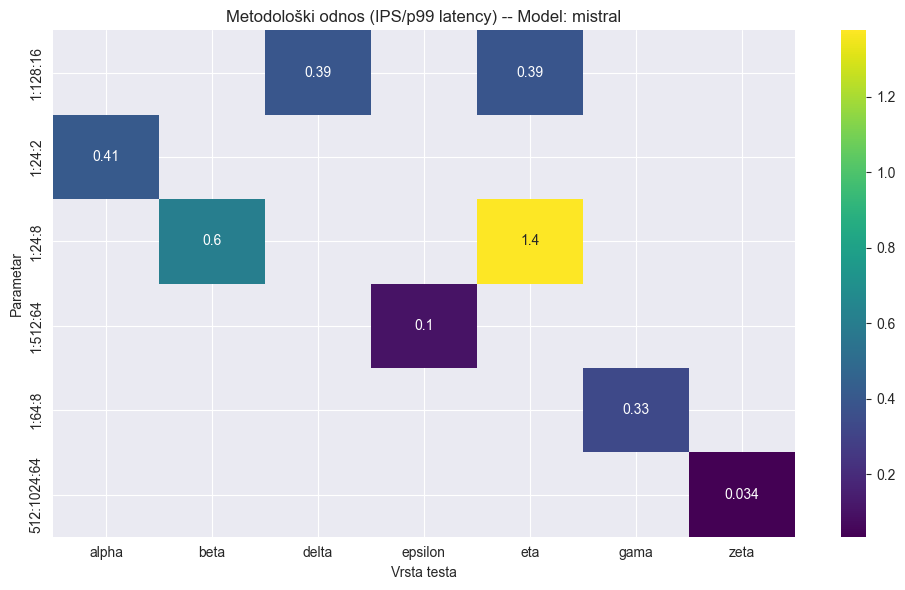

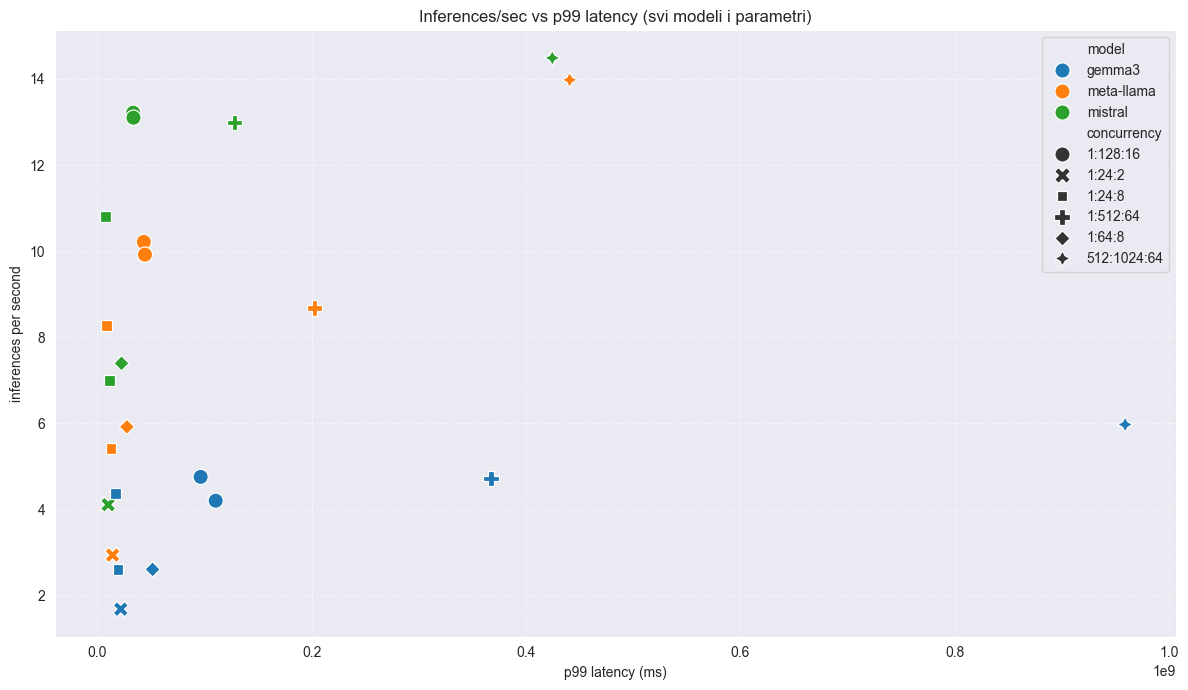

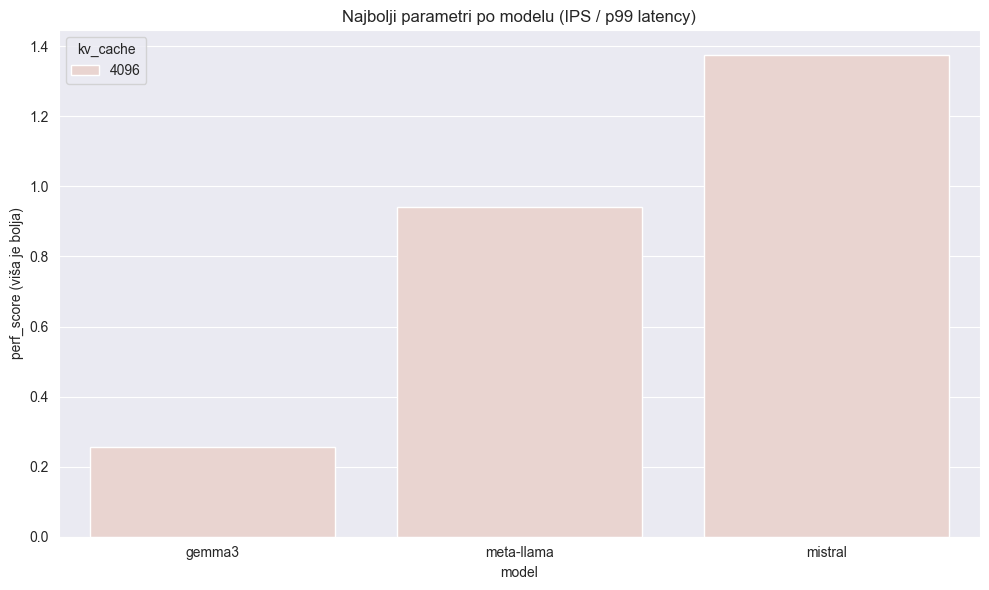

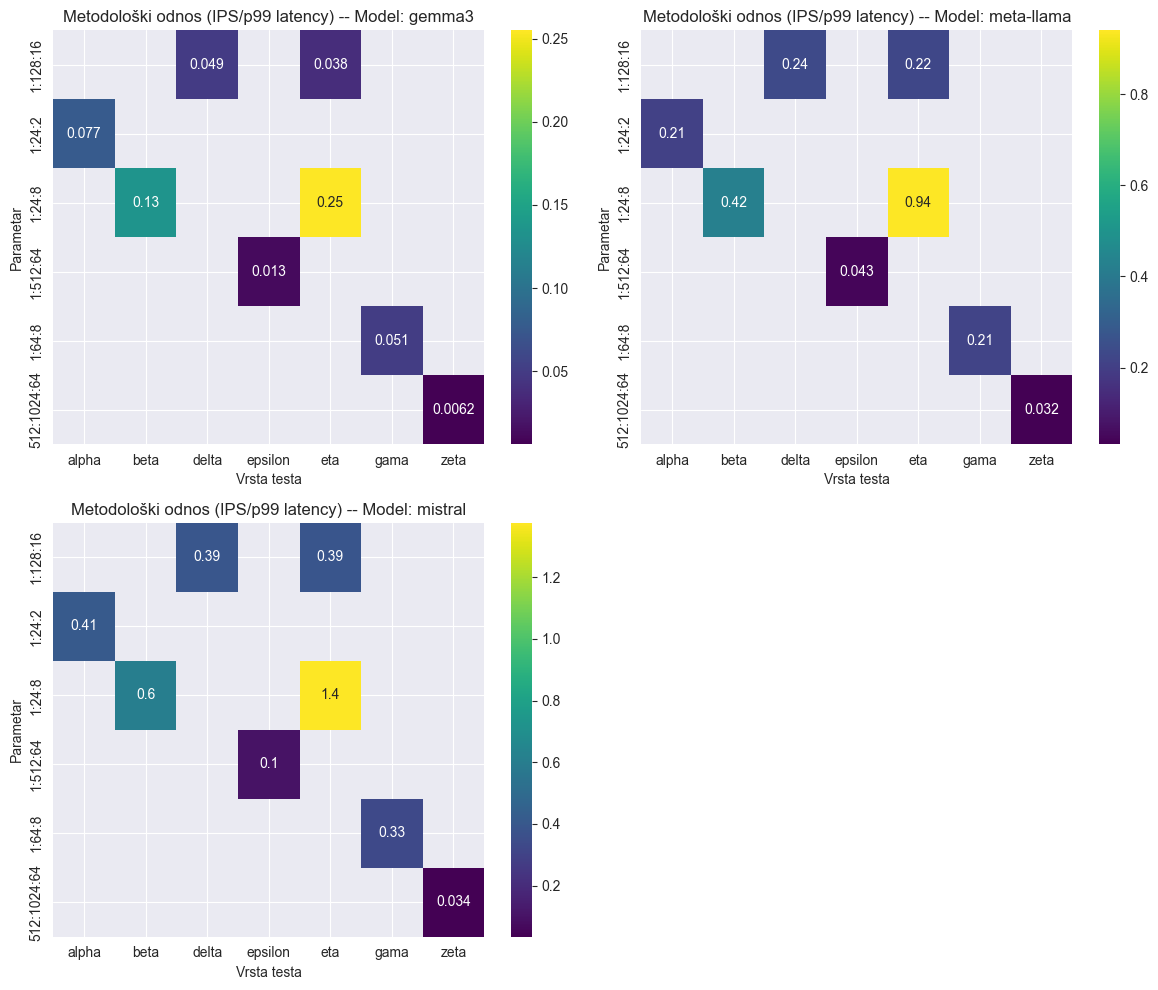

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Učitaj podatke
df = pd.read_csv('metrike/obrada_gotova/triton_rezultati.csv')
# remove -rt from column model
df = df[~df['model'].str.contains('rt-')]
# Prvih nekoliko redova - kontrola uploada
df.head()

# Pretpostavimo da .csv ima kolumne:
# 'parametar', 'model', 'test', 'inferences_per_second', 'p99_latency_ms', ...

# Prikaz osnovne statistike po parametru i modelu
pivot = df.pivot_table(
    values=['Inferences/Second', 'p99 latency'],
    index=['concurrency', 'model', 'test', 'kv_cache'],
    aggfunc='mean'
).reset_index()

# Računanje 'score' metrike kao IPS / p99_latency_ms i prebaci u mikrosekunde
pivot['perf_score'] = (pivot['Inferences/Second'] / pivot['p99 latency']) * 1_000_000

# Heatmapa performansi po parametru (npr. za jedan model):
for model in pivot['model'].unique():
    pivot_model = pivot[pivot['model'] == model]
    plt.figure(figsize=(10, 6))
    p = pivot_model.pivot(index='concurrency', columns='test', values='perf_score')
    sns.heatmap(p, annot=True, cmap='viridis')
    plt.title(f'Metodološki odnos (IPS/p99 latency) -- Model: {model}')
    plt.ylabel('Parametar')
    plt.xlabel('Vrsta testa')
    plt.tight_layout()
    plt.show()

# Scatter plot omjera za sve modele i parametre
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=pivot,
    x='p99 latency',
    y='Inferences/Second',
    hue='model',
    style='concurrency',
    s=120
)
plt.title('Inferences/sec vs p99 latency (svi modeli i parametri)')
plt.xlabel('p99 latency (ms)')
plt.ylabel('inferences per second')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Barplot najboljih parametara po modelu
idxmax = pivot.groupby('model')['perf_score'].idxmax()
best = pivot.loc[idxmax]
plt.figure(figsize=(10, 6))
sns.barplot(data=best, x='model', y='perf_score', hue='kv_cache')
plt.title('Najbolji parametri po modelu (IPS / p99 latency)')
plt.ylabel('perf_score (viša je bolja)')
plt.tight_layout()
plt.show()

import math

models = pivot['model'].unique()
n_models = len(models)
n_cols = 2  # or any number you prefer
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*5), squeeze=False)

for idx, model in enumerate(models):
    row, col = divmod(idx, n_cols)
    pivot_model = pivot[pivot['model'] == model]
    data = pivot_model.pivot(index='concurrency', columns='test', values='perf_score')
    sns.heatmap(data, annot=True, cmap='viridis', ax=axes[row][col])
    axes[row][col].set_title(f'Metodološki odnos (IPS/p99 latency) -- Model: {model}')
    axes[row][col].set_ylabel('Parametar')
    axes[row][col].set_xlabel('Vrsta testa')

# Hide unused subplots
for idx in range(n_models, n_rows * n_cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# UČITAVANJE REZULTATA
# Prilagodi imena CSV-ova!
triton_df = pd.read_csv('metrike/obrada_gotova/triton_rezultati.csv')
triton_df = triton_df[~triton_df['model'].str.contains('rt-')]
df1 = pd.read_csv("metrike/obrada_gotova/prompts_single/1_prompt_test_results.csv")
df2 = pd.read_csv("metrike/obrada_gotova/prompts_single/2_chat_test_results.csv")
df3 = pd.read_csv("metrike/obrada_gotova/prompts_single/3_summarize_test_results.csv")
df4 = pd.read_csv("metrike/obrada_gotova/prompts_single/4_batch_test_results.csv")

user_df = pd.concat([df1, df2, df3, df4], ignore_index=True)

dfa = pd.read_csv("metrike/obrada_gotova/locust/1_prompt_test_results.csv")
dfb = pd.read_csv("metrike/obrada_gotova/locust/2_chat_test_results.csv")
dfc = pd.read_csv("metrike/obrada_gotova/locust/3_summarize_test_results.csv")
dfd = pd.read_csv("metrike/obrada_gotova/locust/4_batch_test_results.csv")


locust_df = pd.concat([dfa, dfb, dfc, dfd], ignore_index=True)   # Pretpostavi ime datoteke

triton_df['test_type'] = 'server'
user_df['test_type'] = 'client'
locust_df['test_type'] = 'stress'
latency_columns = [col for col in triton_df.columns if 'latency' in col.lower()]

for col in latency_columns:
    triton_df[col] = triton_df[col] / 1_000_000


In [64]:
locust_df

,timestamp,test_name,prompt_index,model,prompt,ttft,tpot,tokens_per_sec,latency,prompt_tokens,output_tokens,output_text,status_code,test_type
0,2025-07-25 18:24:20.082775,single,0,mistral,Edit the following sentence to include the ter...,14.161550,0.091982,10.871688,14.165233,26.0,154,Edit the following sentence to include the ter...,200,stress
1,2025-07-25 18:24:20.400474,single,0,meta-llama,Rewrite this story from the point of view of t...,10.752533,0.059760,16.733520,10.756852,52.0,180,Rewrite this story from the point of view of t...,200,stress
2,2025-07-25 18:24:37.240732,single,0,mistral,Determine the capital of Peru.,31.326770,0.232081,4.308840,31.330938,7.0,135,Determine the capital of Peru.\n\nThe capital ...,200,stress
3,2025-07-25 18:24:37.243646,single,0,mistral,Generate a fantasy creature with its unique sp...,31.323705,0.227031,4.404690,31.330242,10.0,138,Generate a fantasy creature with its unique sp...,200,stress
4,2025-07-25 18:24:47.668964,single,0,mistral,Calculate the amount of time required for the ...,29.615530,0.197476,5.063902,29.621429,22.0,150,Calculate the amount of time required for the ...,200,stress
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3689,2025-07-25 18:59:12.588215,batch,3,mistral,Reflect on the given quote and provide an appr...,15.149074,0.105271,9.499267,15.159064,29.0,144,Reflect on the given quote and provide an appr...,200,stress
3690,2025-07-25 18:59:12.588889,batch,4,mistral,Compose a headline and article excerpt about t...,15.149074,0.103829,9.631201,15.159064,18.0,146,Compose a headline and article excerpt about t...,200,stress
3691,2025-07-25 18:59:12.589373,batch,5,mistral,Reverse engineer the following sentence. Bob s...,15.149074,0.104545,9.565234,15.159064,17.0,145,Reverse engineer the following sentence. Bob s...,200,stress
3692,2025-07-25 18:59:12.590001,batch,6,mistral,Explain why computers are better than humans f...,15.149074,0.107511,9.301366,15.159064,13.0,141,Explain why computers are better than humans f...,200,stress


In [55]:


# Najbolji prema Throughput-u
best_throughput = triton_df.loc[triton_df.groupby(['model'])['Inferences/Second'].idxmax()].sort_values(by='Inferences/Second',
                                                                                                 ascending=False)
# filter rows: test, model, batch_size, Throughput, p99_latency, concurrency, Inferences/Second, p50_latency, p90_latency, p95_latency, p99_latency
best_throughput = best_throughput[
    ['test', 'model', 'Inferences/Second', 'p99 latency',  'batch_size', 'concurrency',
     'p50 latency', 'p90 latency', 'p95 latency']]
best_throughput

,test,model,Inferences/Second,p99 latency,batch_size,concurrency,p50 latency,p90 latency,p95 latency
204,delta,mistral,14.81470,11.879197,8,1:128:16,8.725484,11.128219,11.456555
255,zeta,meta-llama,14.02440,294.835316,8,512:1024:64,292.471068,293.208765,293.406337
237,zeta,gemma3,6.06156,1187.884430,8,512:1024:64,1105.226713,1186.877776,1187.672990


In [92]:
# load locust_df and user_df and create a combined dataframe and filter out in heders
# model, test, ttft, tpot, tps, latency, num_tokens
# use average for each metric
# UČITAVANJE REZULTATA
# Prilagodi imena CSV-ova!
triton_df = pd.read_csv('metrike/obrada_gotova/triton_rezultati.csv')
triton_df = triton_df[~triton_df['model'].str.contains('rt-')]
df1 = pd.read_csv("metrike/obrada_gotova/prompts_single/1_prompt_test_results.csv")
df2 = pd.read_csv("metrike/obrada_gotova/prompts_single/2_chat_test_results.csv")
df3 = pd.read_csv("metrike/obrada_gotova/prompts_single/3_summarize_test_results.csv")
df4 = pd.read_csv("metrike/obrada_gotova/prompts_single/4_batch_test_results.csv")

user_df = pd.concat([df1, df2, df3, df4], ignore_index=True)

dfa = pd.read_csv("metrike/obrada_gotova/locust/1_prompt_test_results.csv")
dfb = pd.read_csv("metrike/obrada_gotova/locust/2_chat_test_results.csv")
dfc = pd.read_csv("metrike/obrada_gotova/locust/3_summarize_test_results.csv")
dfd = pd.read_csv("metrike/obrada_gotova/locust/4_batch_test_results.csv")


locust_df = pd.concat([dfa, dfb, dfc, dfd], ignore_index=True)   # Pretpostavi ime datoteke

#combined_df = pd.concat([user_df, locust_df], ignore_index=True)


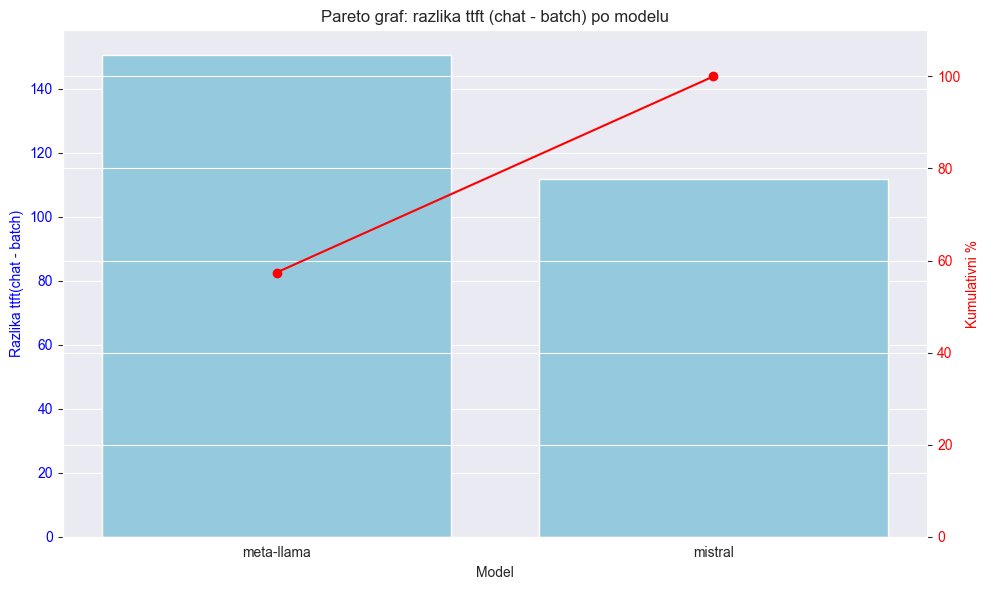

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
combined_df = locust_df
# Filter only Chat and Batch test types
pareto_data = combined_df[combined_df["test_name"].isin(["chat", "batch", "single", "summarizer"])].copy()

# Pivot to get Chat and Batch ttft for each model
pareto_pivot = pareto_data.pivot_table(index="model", columns="test_name", values="ttft",    aggfunc="mean").reset_index()

# Ensure both columns exist
for col in ["chat", "batch", "single", "summarizer"]:
    if col not in pareto_pivot.columns:
        pareto_pivot[col] = float('nan')

# Calculate difference (Chat - Batch)
pareto_pivot["ttft_diff"] = pareto_pivot["chat"] - pareto_pivot["batch"]

# Sort by difference
pareto_sorted = pareto_pivot.sort_values(by="ttft_diff", ascending=False).reset_index(drop=True)

# Cumulative percentage
pareto_sorted["% Kumulativno"] = pareto_sorted["ttft_diff"].cumsum() / pareto_sorted["ttft_diff"].sum() * 100

# --- PARETO GRAF ---
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=pareto_sorted, x="model", y="ttft_diff", ax=ax1, color="skyblue")
ax1.set_ylabel("Razlika ttft(chat - batch)", color="blue")
ax1.set_xlabel("Model")
ax1.tick_params(axis='y', labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(pareto_sorted["model"], pareto_sorted["% Kumulativno"], color="red", marker="o", linestyle="-")
ax2.set_ylabel("Kumulativni %", color="red")
ax2.tick_params(axis='y', labelcolor="red")
ax2.set_ylim(0, 110)

plt.title("Pareto graf: razlika ttft (chat - batch) po modelu")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()